In [55]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT,MOVEMENT
import numpy as np
import random
import numpy as np
from matplotlib import pyplot as plt

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cpu")


In [57]:
def statePreprocess(state):
    state = state[48:208, 96:176]
    grayscale = np.dot(state[...,:3], [0.2989, 0.5870, 0.1140])
    binary_array = grayscale.reshape(20, 8, 10, 8).max(axis=(1, 3)) > 0
    return binary_array.astype(int)

def one_hot_piece(piece):
    mapping = {
        'Tu': 0, 'Tr': 1, 'Td': 2, 'Tl': 3, 'Jl': 4, 'Ju': 5, 'Jr': 6,
        'Jd': 7, 'Zh': 8, 'Zv': 9, 'O': 10, 'Sh': 11, 'Sv': 12, 'Lr': 13,
        'Ld': 14, 'Ll': 15, 'Lu': 16, 'Iv': 17, 'Ih': 18
    }
    if piece not in mapping:
        print(piece)
        return -1
    return mapping[piece]

def simplifiedState(state, current_piece):
    state = statePreprocess(state)
    heights = np.max(state == 1, axis=0)
    return (tuple(heights), current_piece)

In [58]:
def q_learning(env, episodes, alpha, gamma, epsilon):
    q_table = {}
    rewards = []

    for episode in range(episodes):
        total_reward = 0
        state = env.reset()
        state, reward, done, info = env.step(0)
        current_piece = one_hot_piece(info['current_piece'])
        while not done:
            current_simplified_state = simplifiedState(state, current_piece)
            if current_simplified_state not in q_table:
                q_table[current_simplified_state] = np.zeros(len(MOVEMENT))

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_simplified_state])

            next_state, reward, done, info = env.step(action)
            next_current_piece = one_hot_piece(info['current_piece'])
            if next_current_piece == -1:
                break
            next_simplified_state = simplifiedState(next_state, next_current_piece)
            if next_simplified_state not in q_table:
                q_table[next_simplified_state] = np.zeros(len(MOVEMENT))

            old_value = q_table[current_simplified_state][action]
            next_max = np.max(q_table[next_simplified_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[current_simplified_state][action] = new_value

            total_reward += reward
            state = next_state
            current_piece = next_current_piece

        rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode: {episode}, Reward: {total_reward}")
        epsilon *= 0.99

    return q_table, rewards

In [59]:
print(SIMPLE_MOVEMENT)

[['NOOP'], ['A'], ['B'], ['right'], ['left'], ['down']]


Episode: 0, Reward: -20.0
None
None
None
None
Episode: 100, Reward: 12.0
None
Episode: 200, Reward: 3.0
None
None
None
None
Episode: 300, Reward: 80.0
None
None
None
Episode: 400, Reward: 21.0
None
None
None
None
None
Episode: 500, Reward: 46.0
None
None
None
None
None
None
None
Episode: 600, Reward: 5.0
None
None
None
Episode: 700, Reward: 51.0
None
None
None
Episode: 800, Reward: 14.0
None
None
None
None
Episode: 900, Reward: 55.0
None
None


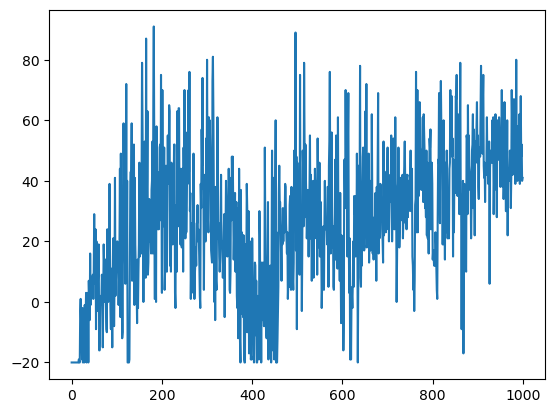

In [60]:
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
episodes = 1000

env = gym_tetris.make('TetrisA-v2')
env = JoypadSpace(env, MOVEMENT)
q_table, rewards = q_learning(env, episodes, alpha, gamma, epsilon)

plt.plot(rewards)
plt.show()
